In [6]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import sys
%config Completer.use_jedi = False

# Part 1
### a.

In [141]:
# SimpleITK read files
# Read mammogram cancer
img = sitk.ReadImage('intra_operative.nii')

In [8]:
# a. function 1: read image and print properties
# properties include size, spacing, origin, direction, pixel type
def image_Info(image):
    """
    :param image: the input image read by SimpleITK
    :return: None
    This function prints the properties of the image. Properties include: size, spacing, origin, direction, pixel type
    """
    print('Size:', image.GetSize()) #size
    print('Space:', image.GetSpacing()) #space
    print('Origin:', image.GetOrigin()) #origin
    print('Direction:', image.GetDirection()) #direction
    print('Pixel Type:', image.GetPixelIDTypeAsString()) #pixel type

In [57]:
# print the information of both files
print('Metainformation of image:')
image_Info(img)

Parameter of image:
Size: (120, 240, 52)
Space: (2.0, 1.0, 3.0)
Origin: (-50.0, -100.0, -50.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel Type: 16-bit signed integer


In [187]:
# a. set 3D slicer as the external viewer
image_viewer = sitk.ImageViewer()
image_viewer.SetApplication('C:/Users/Linda/AppData/Local/NA-MIC/Slicer 4.11.20210226/Slicer.exe')
# view image in 3D slicer
image_viewer.Execute(img)

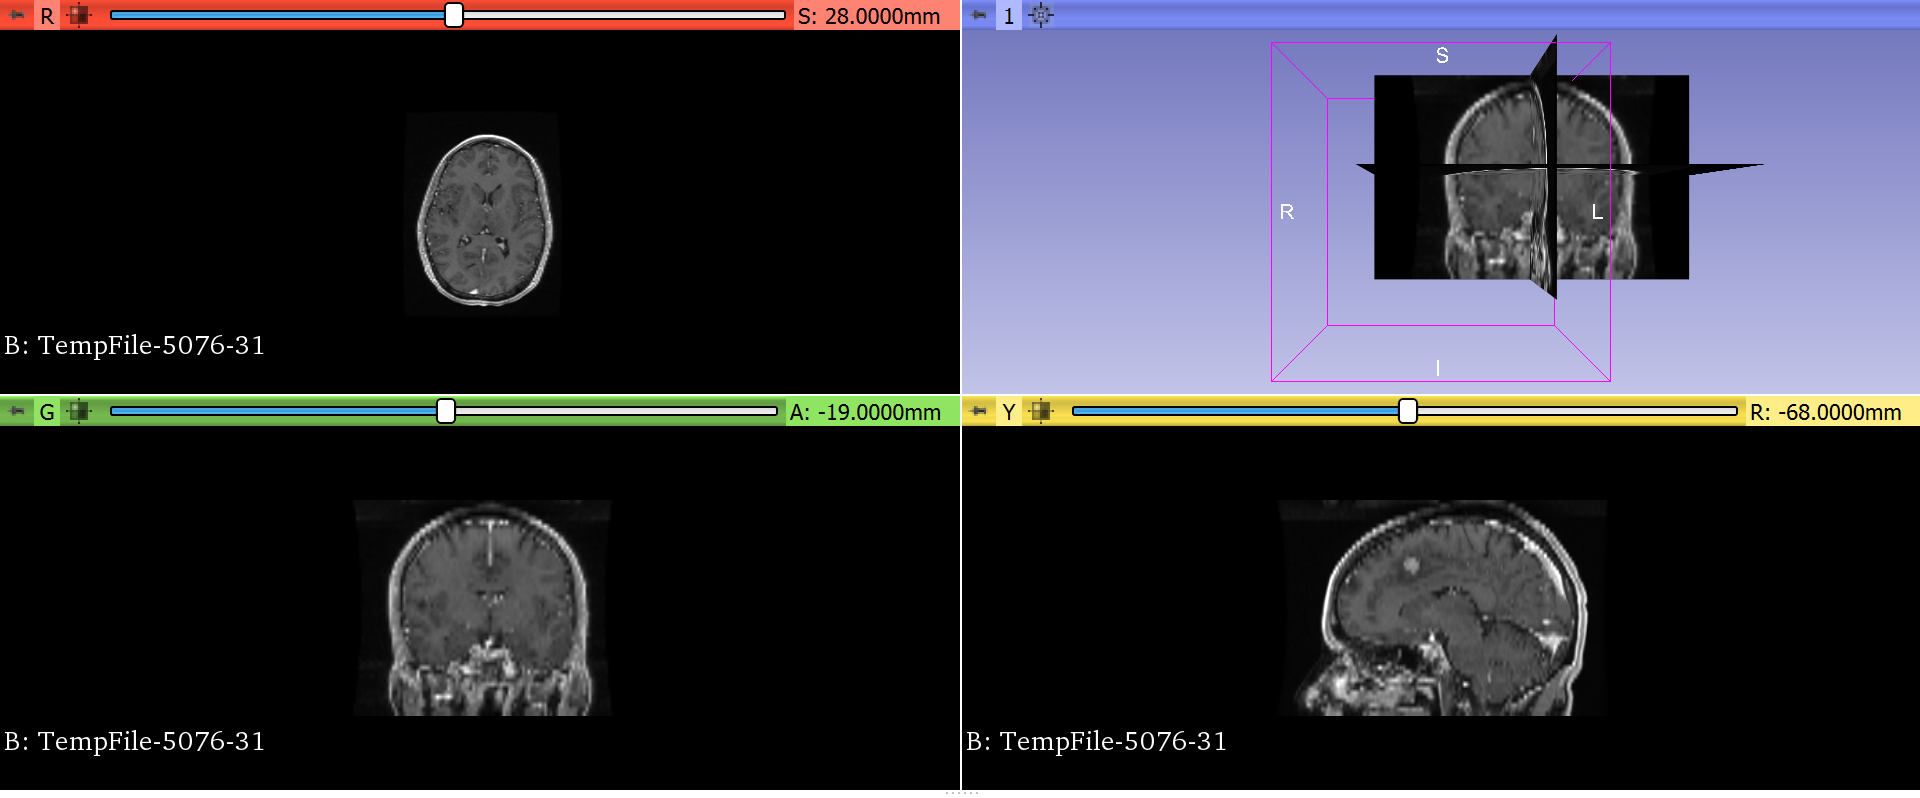

### b.

In [16]:
# i. mathod 1: manually calculate physical extent: size*spacing
print((120*2.0, 240*1.0, 52*3.0))
#Size: (120, 240, 52)
#Space: (2.0, 1.0, 3.0)

(240.0, 240.0, 156.0)


In [18]:
# ii. mathod 2: use TransformIndexToPhysicalPoint()
img.TransformIndexToPhysicalPoint((120, 240, 52))

(190.0, 140.0, 106.0)

There is a different in calculating mathmatically and using TransformIndexToPhysicalPoint() because TransformIndexToPhysicalPoint() function assume the origin of the image which is at (0, 0, 0) and measures the physical location of the image, but calculating it manually calculate the physical extent of the image solely without considering the origin position. Adding up the physical location and the origin which is (-50.0, -100.0, -50.0) in this case, we can obtain the physical extent of the image which is equal to the physical extent calculated manully.

source: https://simpleitk.readthedocs.io/en/master/fundamentalConcepts.html#lbl-image-metadata

### c.

In [20]:
# print the new spacing
print('new spacing:', '(0.5, 0.5, 0.5)')
# calculate and print the new size
print('new size:', (120*2.0/0.5, 240*1.0/0.5, 52*3.0/0.5))
# print the origin
print('origin: (-50.0, -100.0, -50.0)')

new spacing: (0.5, 0.5, 0.5)
new size: (480.0, 480.0, 312.0)
origin: (-50.0, -100.0, -50.0)


To up-sample the image, spacing is reduced to (0.5, 0.5, 0.5) and in order to obtain the same volumn, we increase the size of the image. Image size can be calculated by (old size*old spacing)/(new spacing). After altering the spacing, the origin, direction and pixel type remain the same as only spacing and image size are changed to get a higher resolution.

### d.

In [142]:
# define a function that resample the image to apcing specified by its input parameter
def data_resample(image, new_spacing):
    resample = sitk.ResampleImageFilter()
    # set direction
    resample.SetOutputDirection(image.GetDirection())
    # set origin
    resample.SetOutputOrigin(image.GetOrigin())
    # set new spacing
    resample.SetOutputSpacing(new_spacing)
    # set new size of the image
    orig_size = np.array(image.GetSize(), dtype=np.int)
    orig_spacing = image.GetSpacing()
    new_size = (orig_size*orig_spacing)/new_spacing
    new_size = np.ceil(new_size).astype(np.int)
    new_size = [int(s) for s in new_size]
    resample.SetSize(new_size)

    newimage = resample.Execute(image)
    return newimage

# source: https://github.com/SimpleITK/SimpleITK/issues/561

In [188]:
# apply the function to resample the intra-operative image with spacing(0.5, 0.5, 0.5)
resample_img = data_resample(img, (0.5,0.5,0.5))
# view resampled image in 3D slicer
image_viewer.Execute(resample_img)

<ipython-input-142-147c9719ef4a>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  orig_size = np.array(image.GetSize(), dtype=np.int)
<ipython-input-142-147c9719ef4a>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated

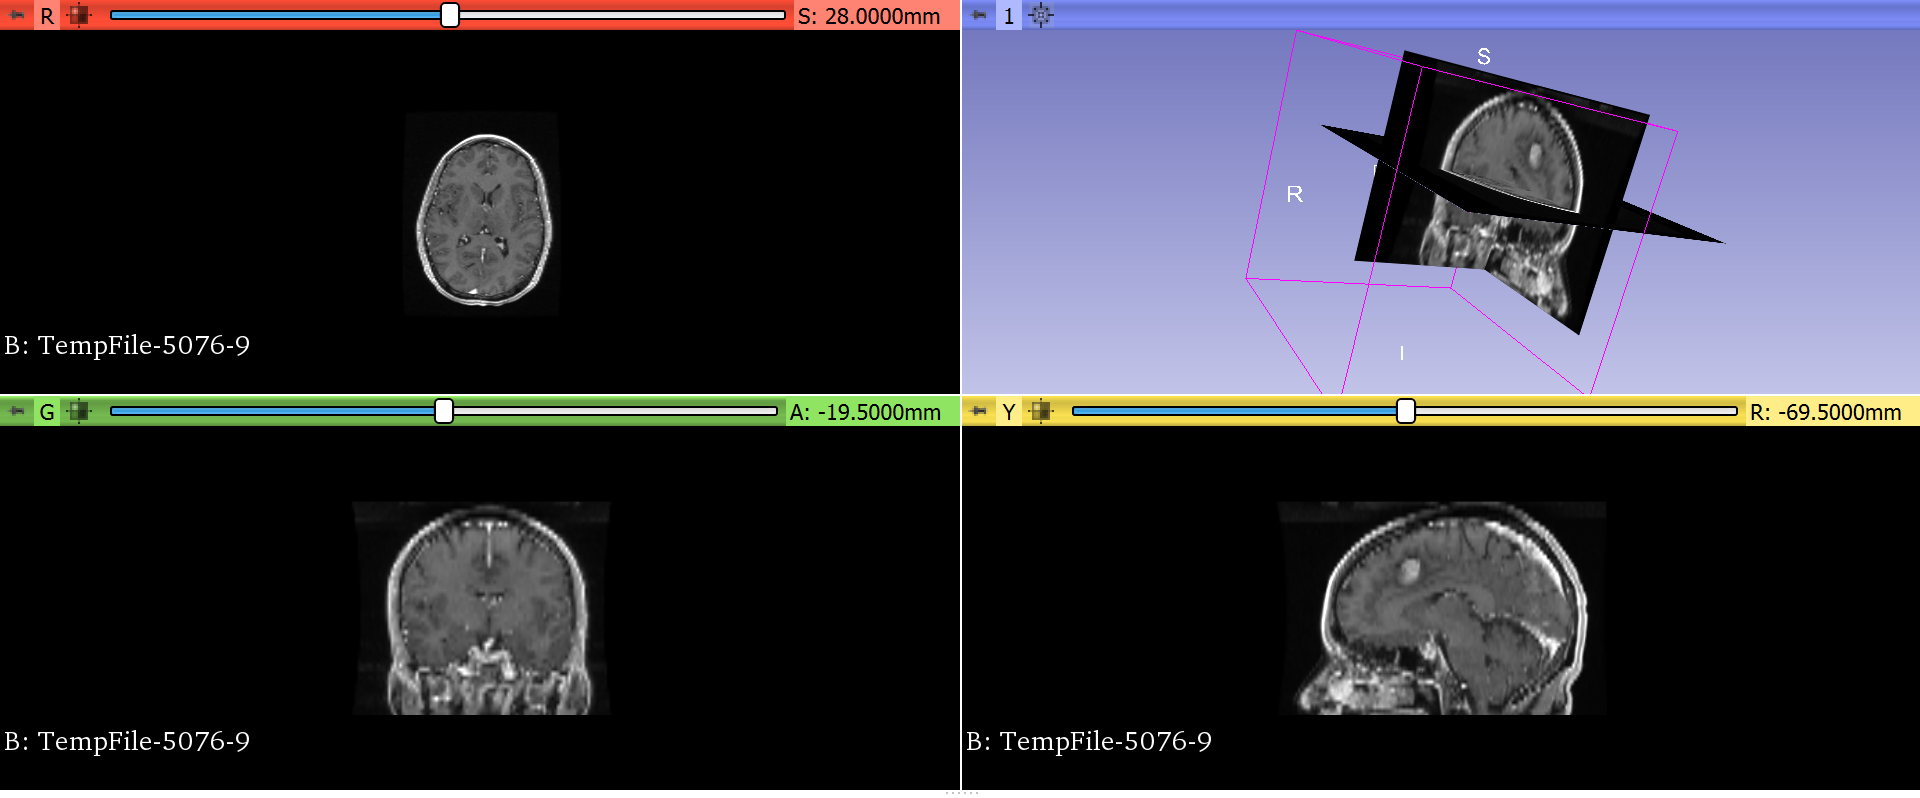

### e.

In [94]:
print('Metainformation of image:')
image_Info(resample_img)

Metainformation of image:
Size: (480, 480, 312)
Space: (0.5, 0.5, 0.5)
Origin: (-50.0, -100.0, -50.0)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Pixel Type: 16-bit signed integer


The meta-information of the resampled image matches the calculation of space and size in part 1.c.

# Part 2

In [95]:
image_Info(resample_img[:,:,0])

Size: (480, 480)
Space: (0.5, 0.5)
Origin: (-50.0, -100.0)
Direction: (1.0, 0.0, 0.0, 1.0)
Pixel Type: 16-bit signed integer


In [193]:
# Rotation function that Rotate image 30 degree counterclockwise around the centre of the iamge
def rotation(image):
    reference_center = (image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize())/2.0))
    rotation3D = sitk.Euler3DTransform()
    rotation3D.SetCenter(reference_center)
    # set the angle (30 degree) for rotation
    rotation3D.SetRotation(0, 0, np.pi/6)
    rotated_image = sitk.Resample(image, rotation3D)
    return rotated_image

# translation function that translate the image 20 mm to R, 10mm to P and 20mm to S
def translation(image):
    t = (20, -10, -20)
    translation3D = sitk.Euler3DTransform()
    translation3D.SetTranslation(t)
    translated_img = sitk.Resample(image, translation3D)
    return translated_img
    
#image_viewer.Execute(rotation(resample_img))
#image_viewer.Execute(translation(resample_img))

# source: http://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/22_Transforms.html

### b.

In [197]:
# apply rotation followed by translation to resampled image
rotated_img1 = rotation(resample_img)
translated_img1 = translation(rotated_img1)

# apply translation followed by rotation to resampled image
translated_img2 = translation(resample_img)
rotated_img2 = rotation(translated_img2)

### c.

In [198]:
# view the image with translation followed by rotation in 3D slicer
image_viewer.Execute(translated_img1)

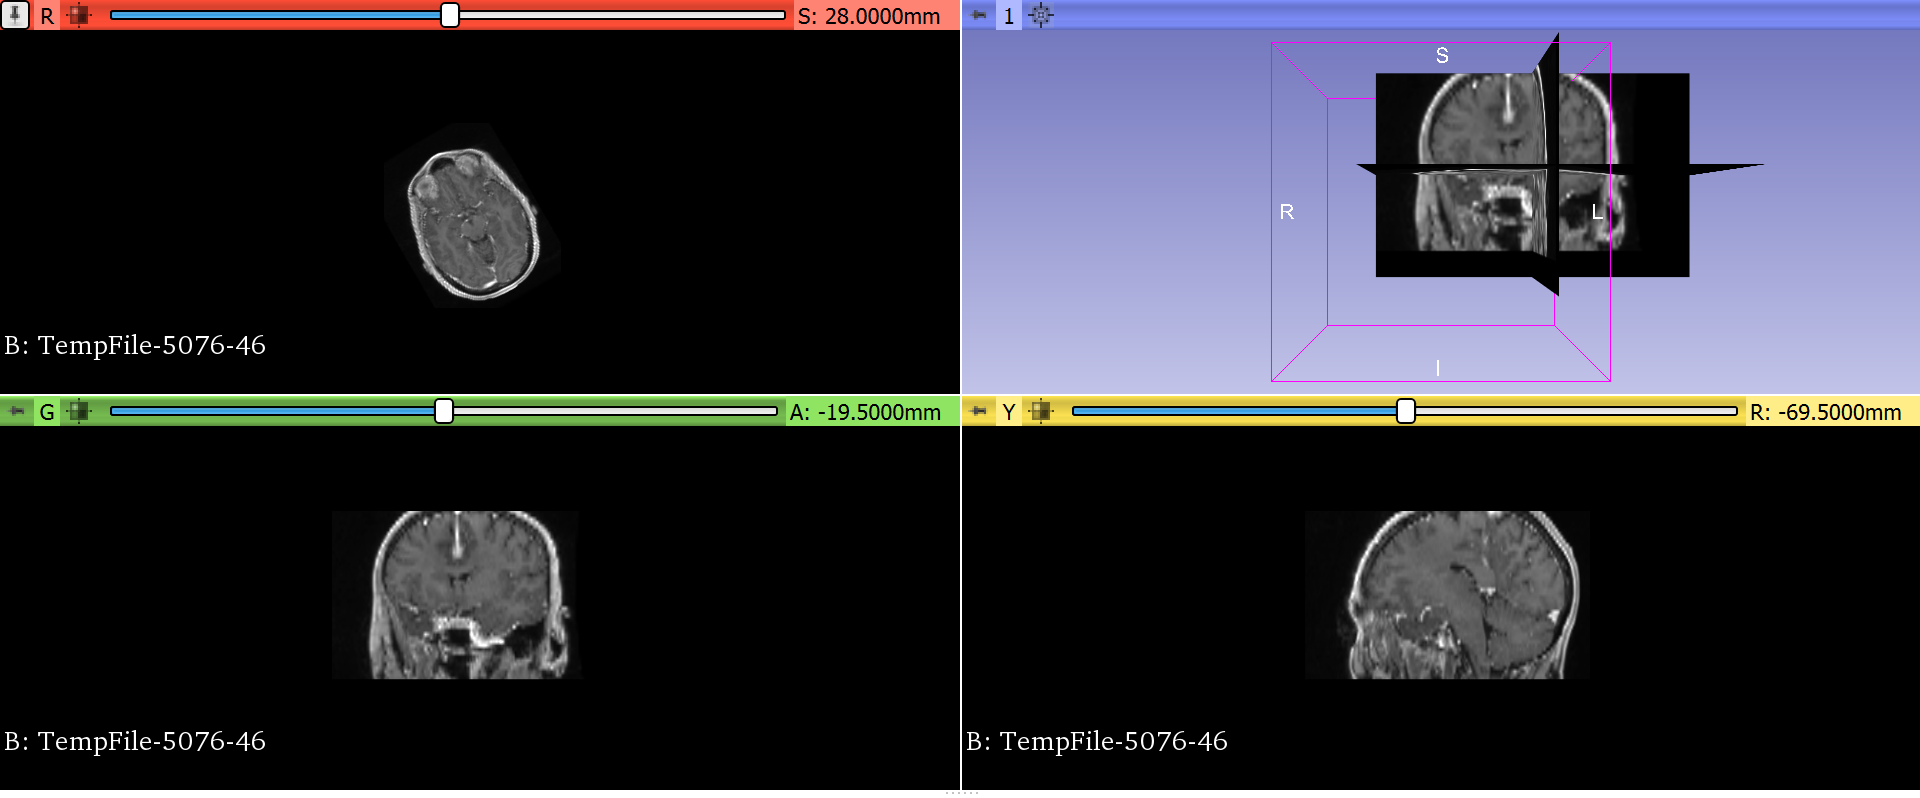

In [201]:
# view the image with translation followed by rotation in 3D slicer
image_viewer.Execute(rotated_img2)

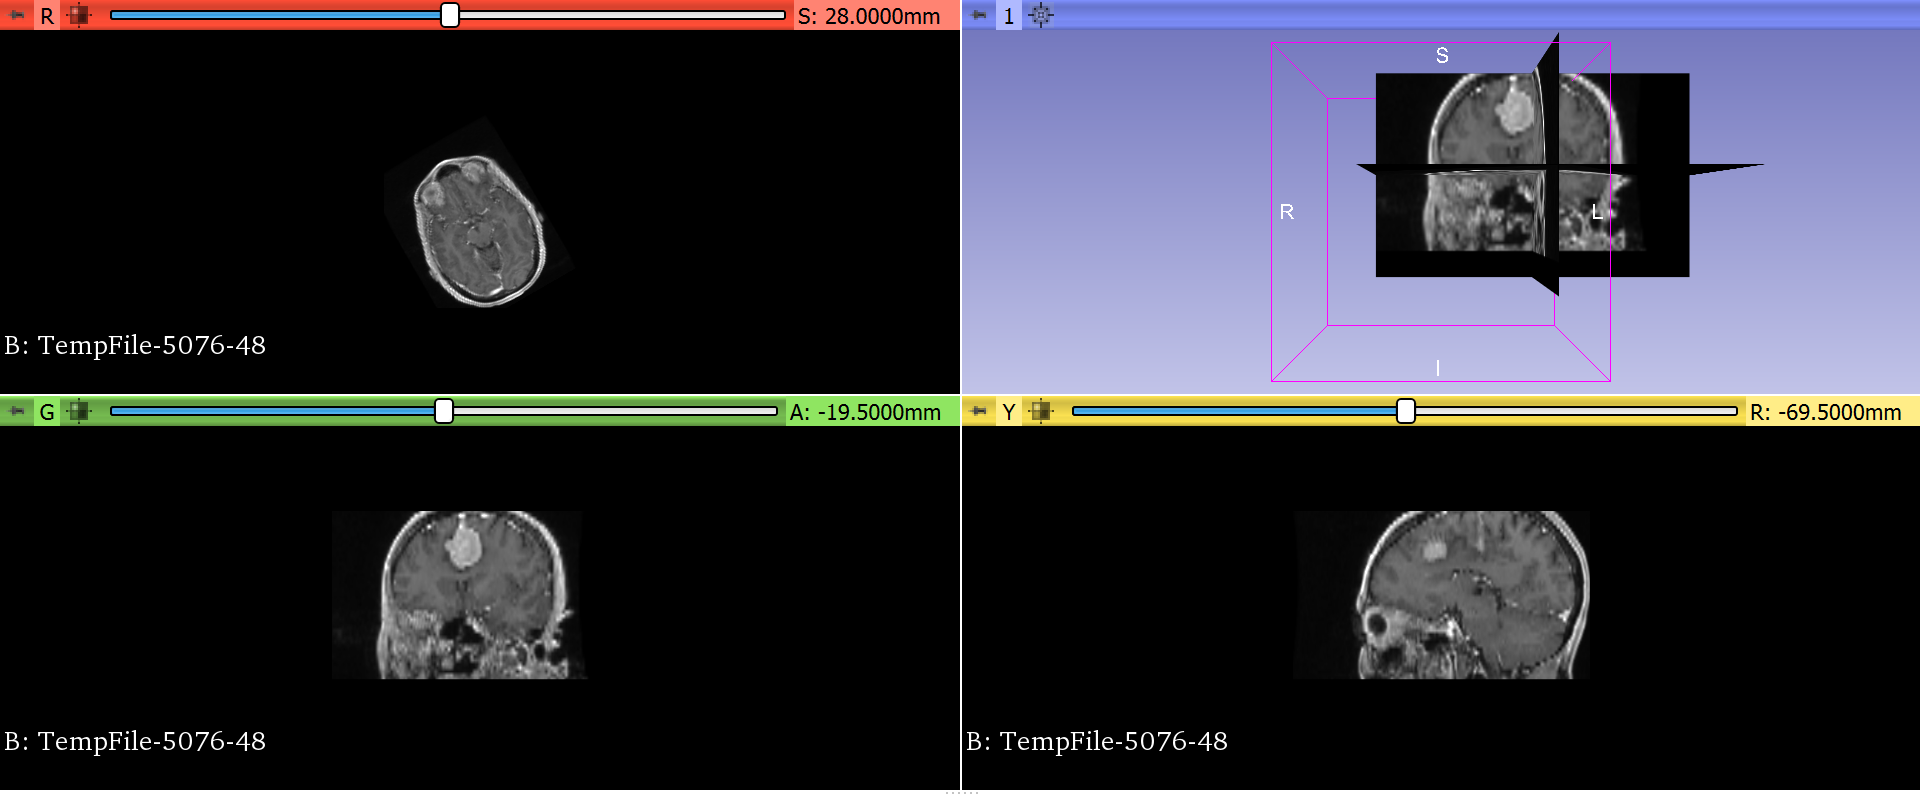

The final volume is sensitive to the order of transformation. This is because the rotation center is set to be (480/2, 480/2, 312/2), if translation is applied first, the rotation center is no longer the center of the image, thereby the image is not rotating around its center. However, when rotation is applied before translation, the image is rotated around its center and then translated to a new location.

# Part 3

### a.

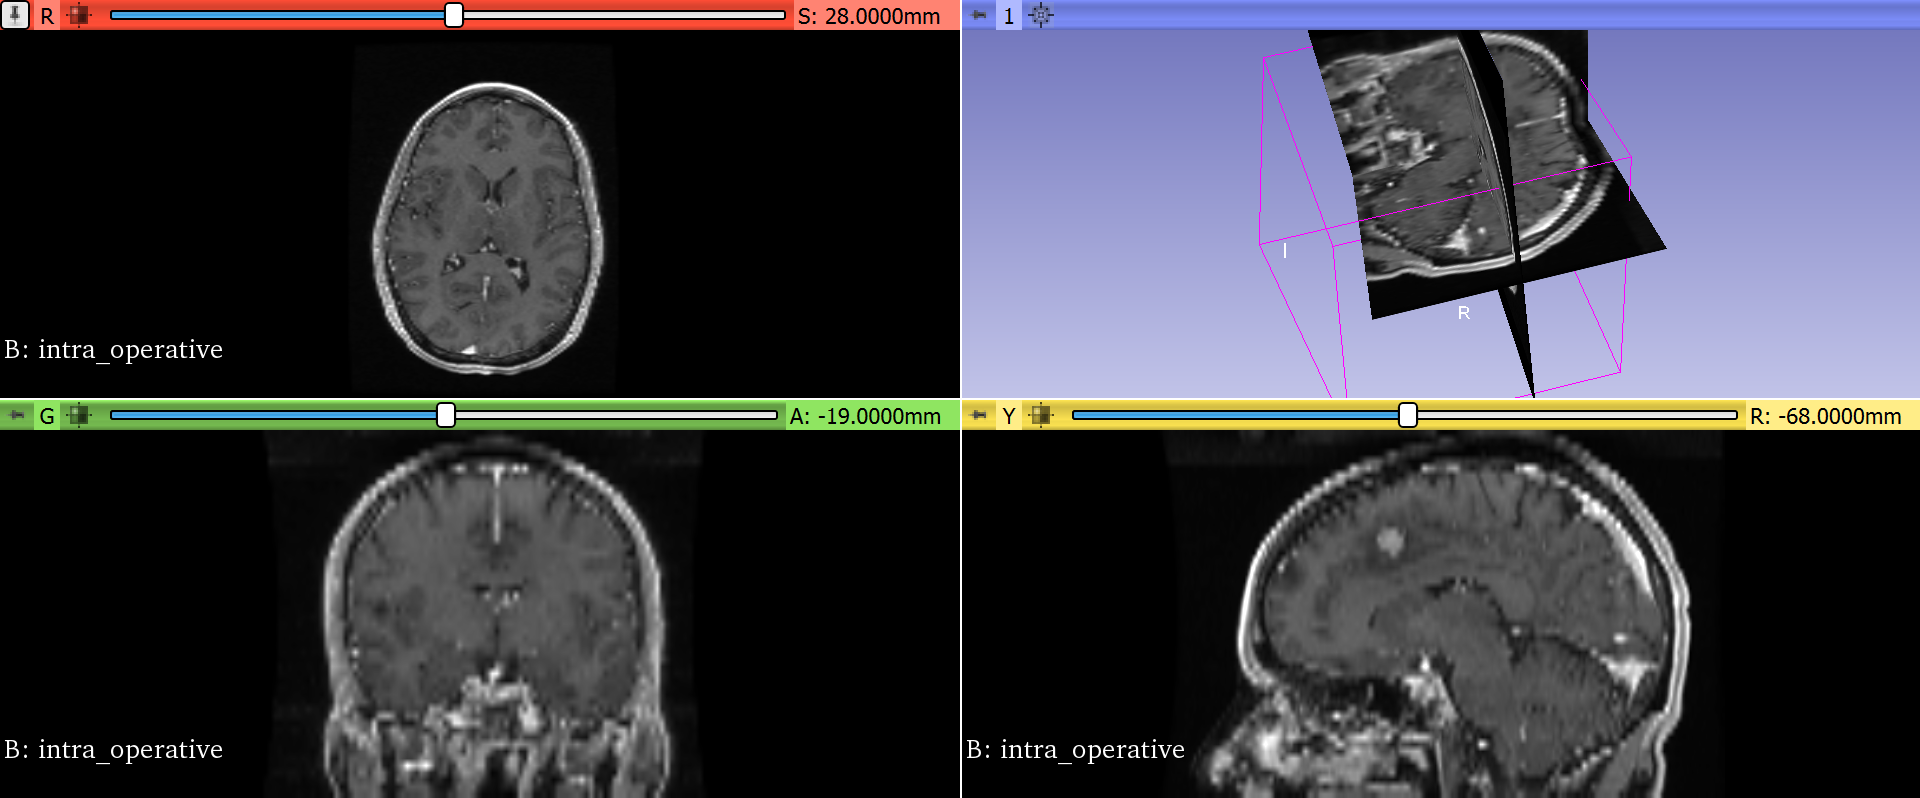


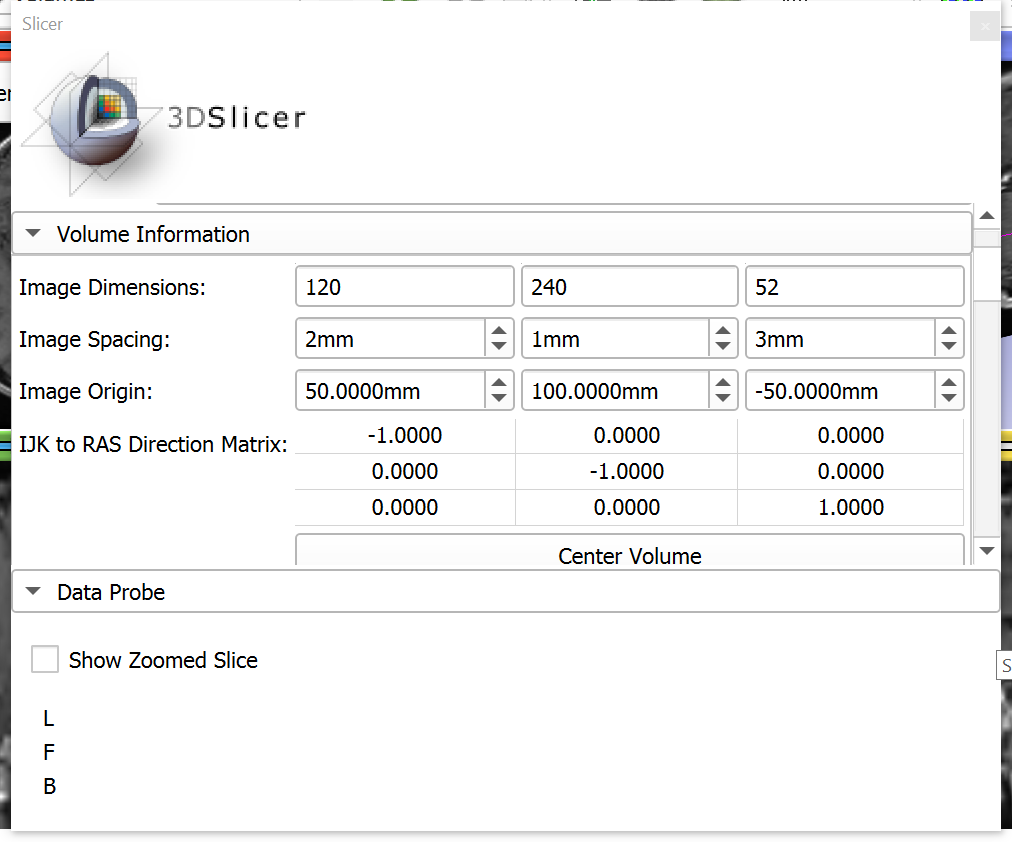

The origin and direction are different. The origin and directions are (-50.0, -100.0, -50.0)
and (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) respectively for information from part 1. The origin and directions are (50.0, 100.0, -50.0) and (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0).

### b.

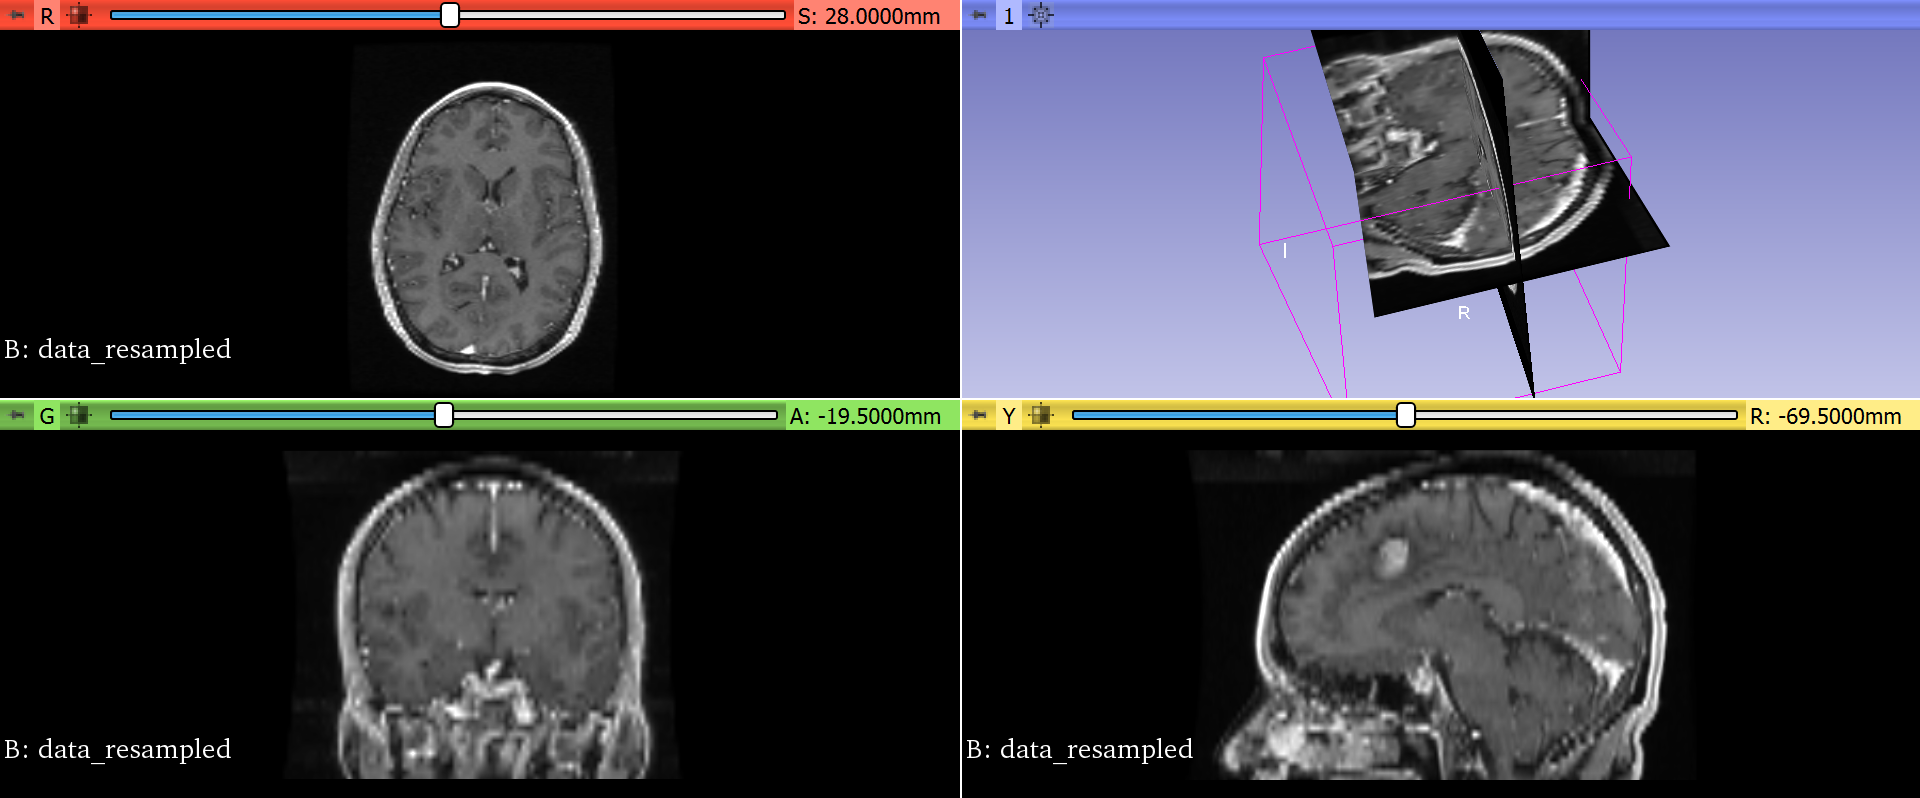


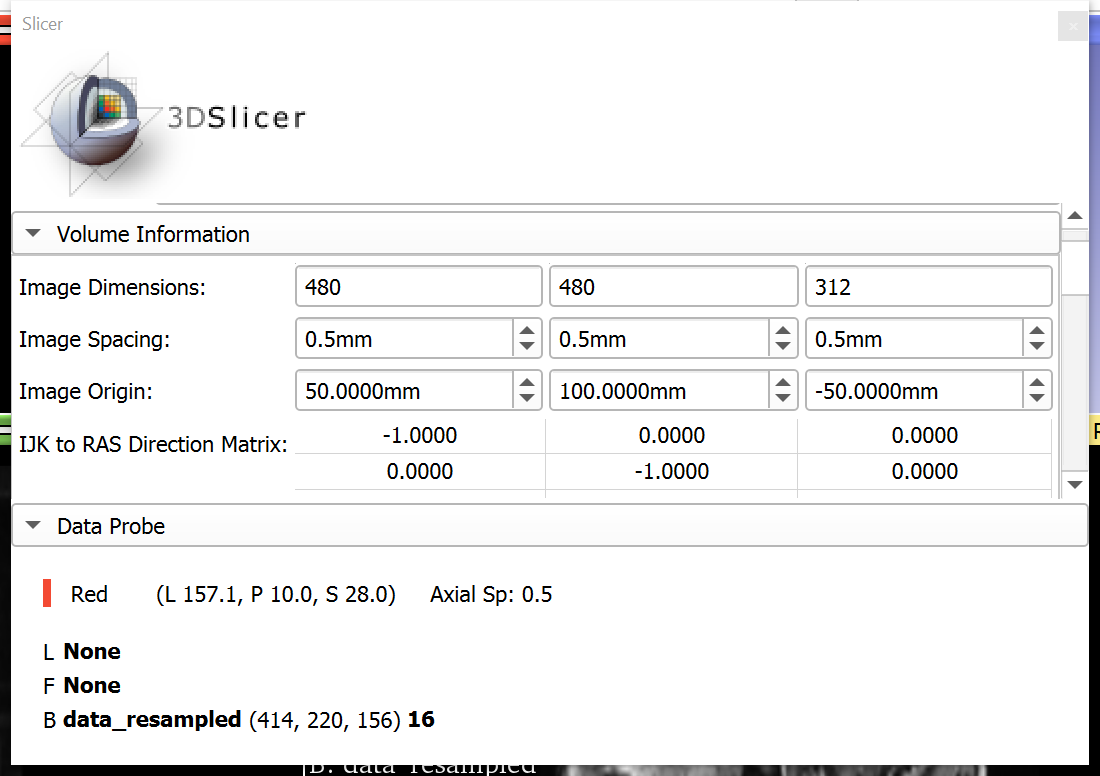

The size and spacing are the same compared with part1 e. However, similar to part a, the origin and direction are differ from part 1's. 

### c.

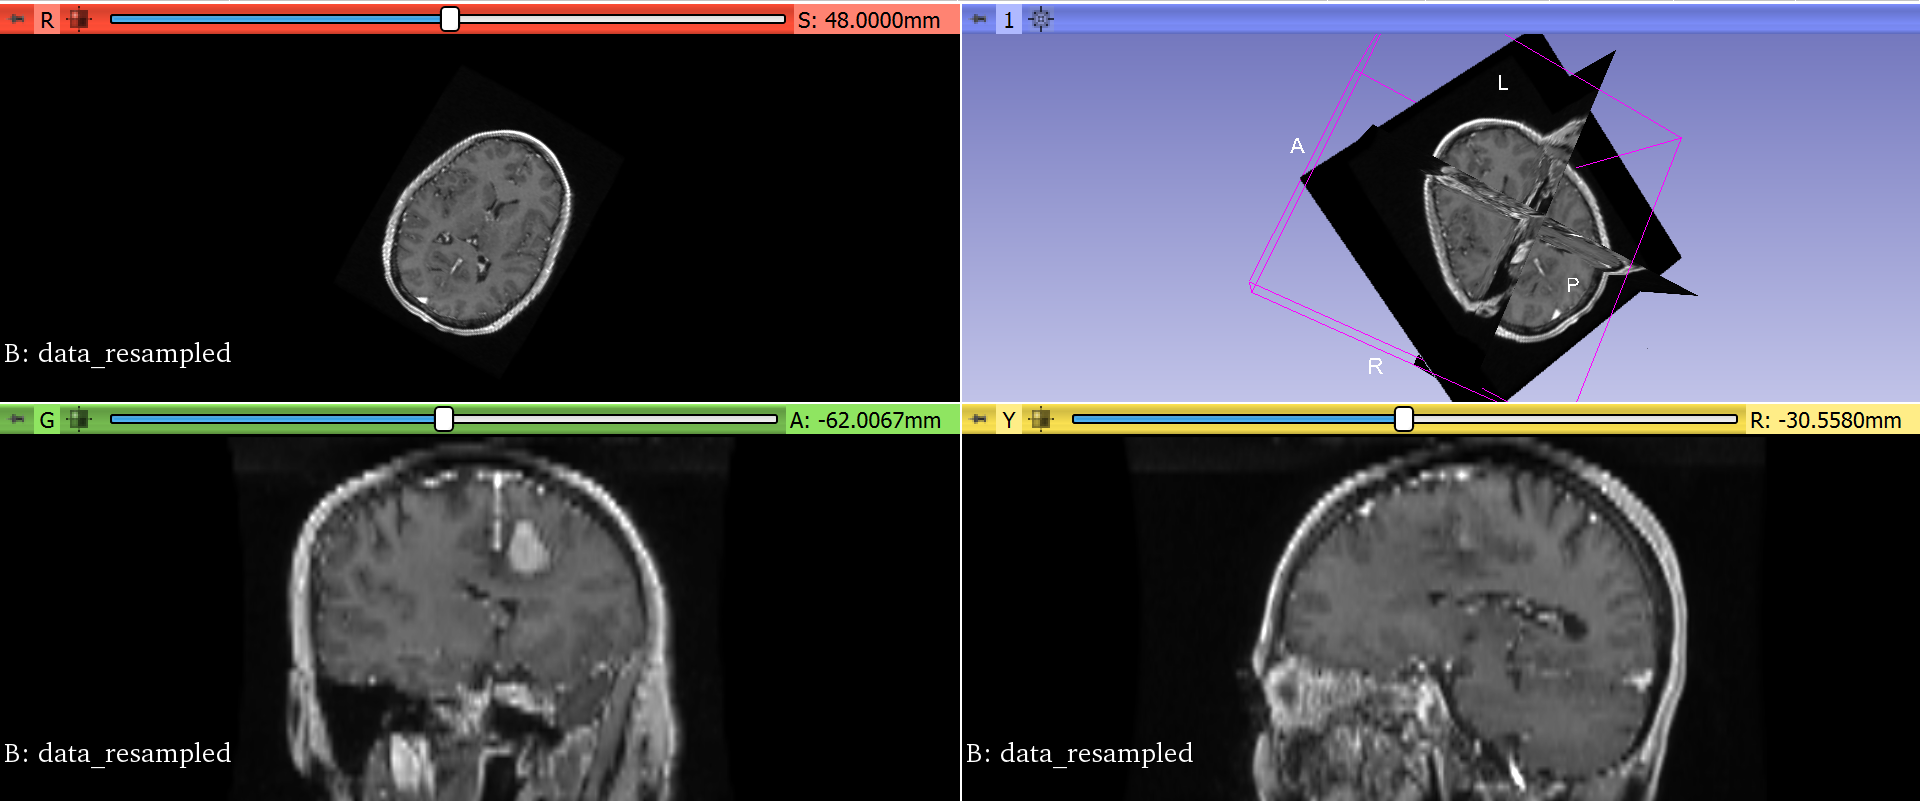

The visulization is different from the ones generated in part2c. This might because in slicer, the rotation center is not specified and it is rotating around (0,0,0), whereas in part2c, the rotation center is (480/2, 480/2, 312/2).